In [1]:
from PIL import Image
import numpy as np
import scipy.stats as stats

In [2]:
filename = "./monalisa.jpg"
img = Image.open(filename)

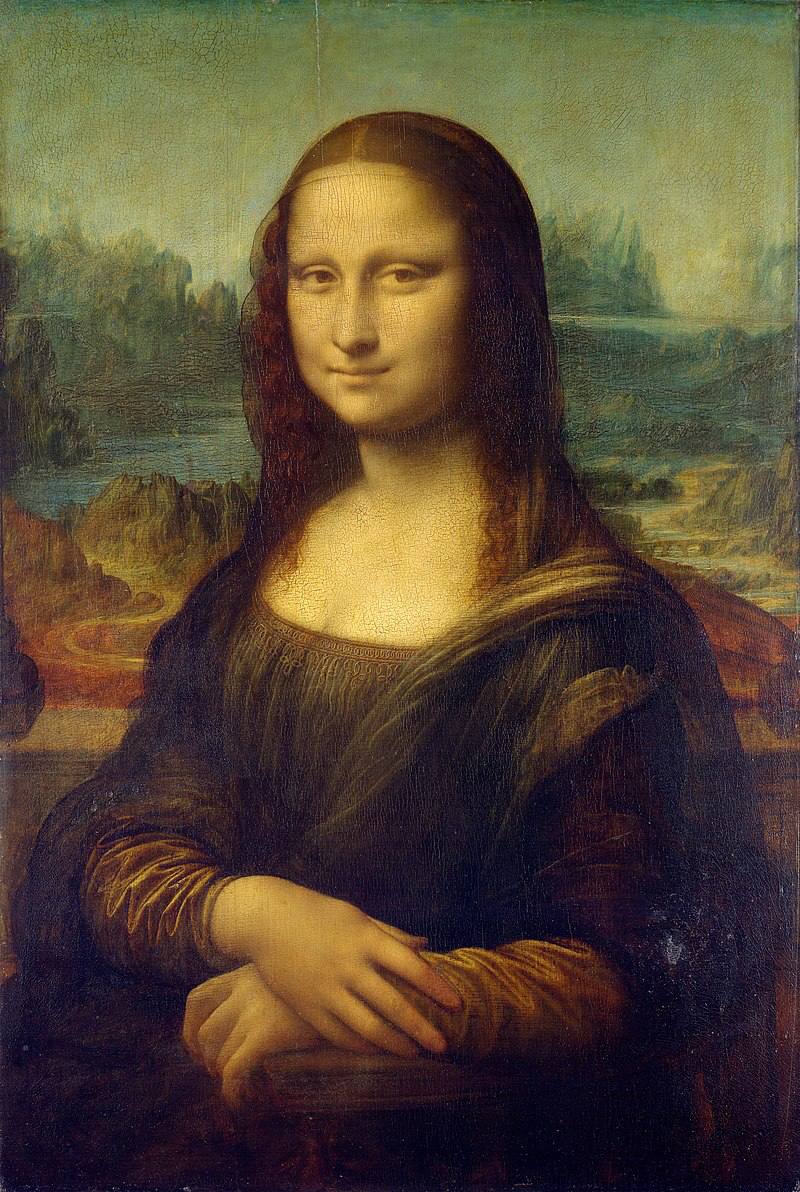

In [3]:
img

In [4]:
idata = np.asarray(img)
idata_ = np.mean(idata, axis=2) # simple arithmetic mean, as done by the paper
idata = np.uint32(idata_)
img2 = Image.fromarray(idata)

In [5]:
COLMAX, ROWMAX = img2.size # Get image size (width, height) i.e. column followed by row

In [6]:
argsort_results = np.uint32(np.zeros([(ROWMAX-1)*(COLMAX-1), 4]))

In [7]:
acounter = 0
for i in np.arange(0, ROWMAX-1, 1):
    for j in np.arange(0, COLMAX-1, 1):
        window1 = idata[i:i+2, j:j+2]  # plus 2 makes it actually 2x2 otherwise it's 1x1
        wflat = window1.flatten()
        argsort1 = np.uint32(np.argsort(wflat, kind='stable')) # in case of tie, preserve original order. mentioned in paper.
        argsort_results[acounter] = argsort1
        acounter = acounter+1

In [8]:
elements, counts = np.unique(argsort_results, axis=0, return_counts=True)

In [9]:
def nse(p):  # normalized shannon entropy
    return (stats.entropy(p) / np.log(p.shape[0]))

def D(p, u): # equation 3
    return nse((p+u)/2) - nse(p/2) - nse(u/2)

In [10]:
n = 24
p = counts / n  # probability distribution
h = nse(p) # normalized shannon entropy... equation 1
Dstar = -0.5 * ( (n+1)/n*np.log(n+1) + np.log(n) - 2*np.log(2*n) ) # equation 4
u = np.array([1/n]*elements.shape[0]) # uniform distribution

C = (D(p,u) * h) / Dstar # Equation 2

In [13]:
print (f"File {filename}: complexity = {C:.6f}, Entropy = {h:.6f}")

File ./monalisa.jpg: complexity = -1.631735, Entropy = 0.988304
